## 1. Data Preparation


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Add the project root to the path so we can import the src modules
sys.path.append('..')

# Import the data generator
from src.data_generator import HybridSystemDataGenerator

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


### 1.1 Generate or Load Dataset


In [15]:
# Check if dataset already exists
dataset_path = 'data/gen_data_test.csv'
generate_new_data = False  # Set to True to generate new data

if generate_new_data or not os.path.exists(dataset_path):
    print("Generating new dataset...")
    data_gen = HybridSystemDataGenerator(seed=RANDOM_SEED)
    # Generate dataset for 1 year
    df = data_gen.generate_dataset(
        start_date='2023-01-01',
        periods_years=1,
        output_file=dataset_path
    )
    print(f"Dataset generated and saved to {dataset_path}")
else:
    print(f"Loading existing dataset from {dataset_path}")
    df = pd.read_csv(dataset_path)
    # If the index is a datetime, parse it
    if 'Unnamed: 0' in df.columns:
        df = df.rename(columns={'Unnamed: 0': 'datetime'})
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
    print("Dataset loaded successfully")


Generating new dataset...
Generating time series base...
Generating weather conditions...
Generating load profile...
Simulating solar PV system...
Simulating battery system...
Simulating grid connection...
Simulating diesel generator...
Injecting faults...
Validating data...
Saving dataset to data/gen_data_test.csv...
Dataset generated and saved to data/gen_data_test.csv


In [16]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")

Dataset shape: (8760, 42)


### 1.2 Define Target and Features



Target distribution (fault_occurred):
fault_occurred
False    8118
True      642
Name: count, dtype: int64
Percentage of faults: 7.33%


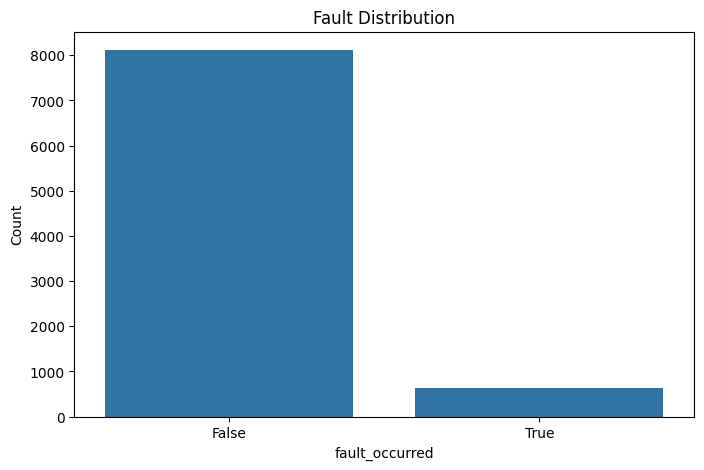

In [17]:
# Define our target variable for fault detection
# Based on the df_info.txt, we'll use 'fault_occurred' as our binary target
target_col = 'fault_occurred'

# Check target distribution
print(f"\nTarget distribution ({target_col}):")
print(df[target_col].value_counts())
print(f"Percentage of faults: {df[target_col].mean() * 100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=df)
plt.title('Fault Distribution')
plt.ylabel('Count')
plt.show()

In [18]:
# Select features (exclude fault-related columns and any non-numeric columns)
feature_cols = [col for col in df.columns 
                if not col.startswith('fault_') 
                and col != target_col
                and pd.api.types.is_numeric_dtype(df[col].dtype)]

print(f"Selected {len(feature_cols)} features for model training")
print(f"First 10 features: {feature_cols[:10]}")


Selected 35 features for model training
First 10 features: ['weather_hour', 'weather_day_of_year', 'weather_is_weekend', 'hour', 'day_of_year', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']


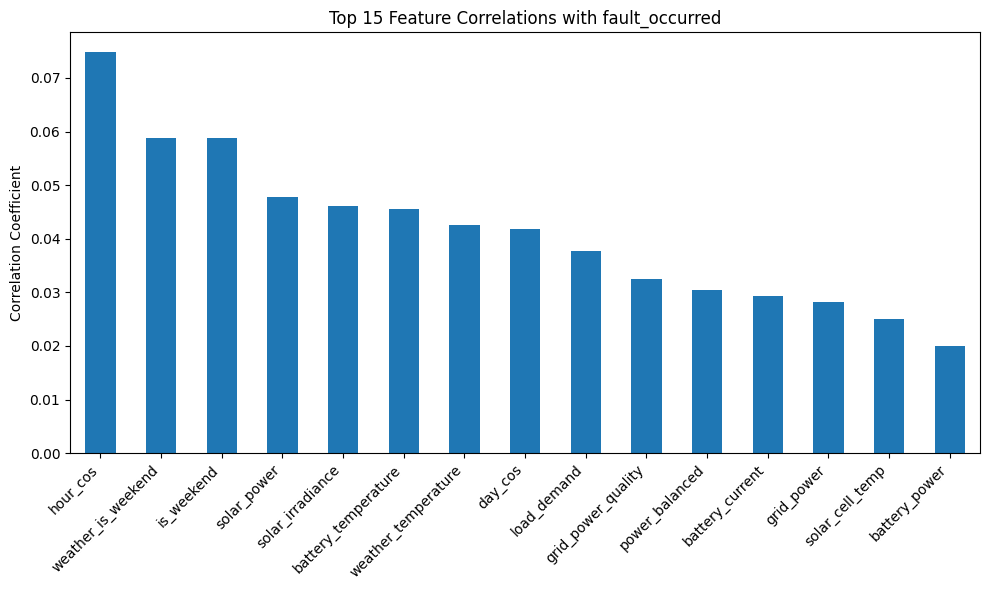

In [19]:
# Calculate feature correlation with target
if pd.api.types.is_numeric_dtype(df[target_col]) or pd.api.types.is_bool_dtype(df[target_col]):
    # Convert boolean to int if needed
    y_corr = df[target_col].astype(int) if pd.api.types.is_bool_dtype(df[target_col]) else df[target_col]
    correlations = df[feature_cols].corrwith(y_corr)
    top_correlations = correlations.abs().sort_values(ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    top_correlations.plot(kind='bar')
    plt.title(f'Top 15 Feature Correlations with {target_col}')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [20]:
# Prepare data for modeling
X = df[feature_cols]
y = df[target_col].astype(int)  # Convert boolean to int if needed


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

In [23]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target distribution in training set: {np.bincount(y_train)}")
print(f"Target distribution in testing set: {np.bincount(y_test)}")

Training set shape: (7008, 35)
Testing set shape: (1752, 35)
Target distribution in training set: [6494  514]
Target distribution in testing set: [1624  128]


## 2. Model Training with Hyperparameter Tuning


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [ ]:
print("Training Random Forest model with hyperparameter tuning...")
start_time = time.time()

In [ ]:
# Define the parameter grid for RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

In [ ]:
# Initialize Random Forest model
rf_base = RandomForestClassifier(random_state=RANDOM_SEED)

In [ ]:
# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=RANDOM_SEED,
    n_jobs=-1,  # Use all available cores
    scoring='f1'  # Optimize for F1 score
)

In [ ]:
# Fit RandomizedSearchCV
rf_random.fit(X_train_scaled, y_train)

In [ ]:
# Get best parameters and model
rf_best_params = rf_random.best_params_
rf_best_model = rf_random.best_estimator_

In [ ]:
print(f"\nBest Random Forest Parameters:")
for param, value in rf_best_params.items():
    print(f"{param}: {value}")

In [ ]:
# Make predictions with best model
y_pred_rf = rf_best_model.predict(X_test_scaled)
y_prob_rf = rf_best_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Calculate metrics
rf_time = time.time() - start_time
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

In [ ]:
print(f"\nRandom Forest training time: {rf_time:.2f} seconds")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest AUC-ROC: {rf_auc:.4f}")

In [ ]:
# Display confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fault', 'Fault'],
            yticklabels=['No Fault', 'Fault'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Feature importance from Random Forest
if hasattr(rf_best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()


In [ ]:
import xgboost as xgb

print("Training XGBoost model with hyperparameter tuning...")
start_time = time.time()

In [ ]:
# Define the parameter grid for RandomizedSearchCV
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # For imbalanced datasets
}


In [ ]:
# Initialize XGBoost model
xgb_base = xgb.XGBClassifier(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss')

In [ ]:
# Set up RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=RANDOM_SEED,
    n_jobs=-1,  # Use all available cores
    scoring='f1'  # Optimize for F1 score
)


In [ ]:
# Fit RandomizedSearchCV
xgb_random.fit(X_train_scaled, y_train)

In [ ]:
# Get best parameters and model
xgb_best_params = xgb_random.best_params_
xgb_best_model = xgb_random.best_estimator_

In [ ]:
print(f"\nBest XGBoost Parameters:")
for param, value in xgb_best_params.items():
    print(f"{param}: {value}")

In [ ]:
# Make predictions with best model
y_pred_xgb = xgb_best_model.predict(X_test_scaled)
y_prob_xgb = xgb_best_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Calculate metrics
xgb_time = time.time() - start_time
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

In [ ]:
print(f"\nXGBoost training time: {xgb_time:.2f} seconds")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost F1 Score: {xgb_f1:.4f}")
print(f"XGBoost Precision: {xgb_precision:.4f}")
print(f"XGBoost Recall: {xgb_recall:.4f}")
print(f"XGBoost AUC-ROC: {xgb_auc:.4f}")

In [ ]:
# Display confusion matrix for XGBoost
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Fault'],
            yticklabels=['No Fault', 'Fault'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Feature importance from XGBoost
if hasattr(xgb_best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': xgb_best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances from XGBoost')
    plt.tight_layout()
    plt.show()

In [ ]:
# Create a DataFrame to compare model performance
models = ['Random Forest', 'XGBoost']
accuracy = [rf_accuracy, xgb_accuracy]
f1 = [rf_f1, xgb_f1]
precision = [rf_precision, xgb_precision]
recall = [rf_recall, xgb_recall]
auc = [rf_auc, xgb_auc]
training_time = [rf_time, xgb_time]


In [ ]:
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC-ROC': auc,
    'Training Time (s)': training_time
})

In [ ]:
print("Model Performance Comparison:")
# Visualize model comparison
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(f'Model Comparison - {metric}')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


## 4. Save Models for Deployment


In [ ]:
import joblib

# Create directory for models
os.makedirs('../models', exist_ok=True)

# Save Random Forest model
joblib.dump(rf_best_model, '../models/rf_fault_detection.pkl')

# Save XGBoost model
joblib.dump(xgb_best_model, '../models/xgb_fault_detection.pkl')

# Save scaler
joblib.dump(scaler, '../models/feature_scaler.pkl')

# Save feature list
with open('../models/feature_list.txt', 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")
